# FEATURE TRACKING

There are three main steps for feature tracking. As discussed in the async lecture, the feature tracking has many applications like depth estimation, motion estimation, object tracking, image alignment, image stitching etc. Feature tracking is comprised of the following three steps:

### 1) Feature Detection:
In order to track objects in the image, we first need to find good features. As described in the lecture, a good feature is that which can be uniquely identified in its neighborhood. Image corners are one such good feature and Harris Corner Detection is used to find corners in the images.

### 2) Feature Description:
After we have the locations of good features, we need to describe the properties of the features so that we can search for them in another image. One simple description can be image pixel values. This feature description, however, is susceptible to illumination, scale, and orientation changes. There are many other more robust feature descriptions like SIFT, SURF etc.

### 3) Feature Matching:
In applications where we have to align two images or track/search an object in an image, we can extract and describe the features in the two images and then match the features using the brute-force matching algorithm shown here.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib

In [ ]:
# read grayscale image with intensity range between 0-1
def read_image(in_path):
    img = np.array(Image.open(urllib.request.urlopen(in_path)))

    # convert to floating point image with intensity [0, 1]
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0

    # convert to grayscale
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

# load images
grid_img = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/checkerboard.png')
grid_img_blur = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/checkerboard_blurr.png')
grid_img_contrast = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/checkerboard_low_contrast.png')
grid_img_translate = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/checkerboard_translate.png')
grid_img_rotate = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/checkerboard_rotate.png')

girf_img_1 = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/girf_1.png')
girf_img_2 = read_image('https://raw.githubusercontent.com/W281/fileRepository/main/live_session/girf_2.png')

############################### FEATURE DETECTION ####################################


In [ ]:
# compute the key points from input grayscale images
def HarrisKeypointDetector(in_image, n, w, k, verbose=False):

    # STEP 1:
    # compute the points where there are good corners in the image
    # for reference the score for good corners are computed as follows:
    # harrisImage = det(H) - k(trace(H))^2
    # where H = A.T*A seen in the async lecture

    # parameters to cv2.cornerHarris are:
    #   grayscale image
    #   n = size of the window to compute the A
    #   w = size of the kernel to compute the gradients
    #   k = value for k in det(H) - k(trace(H))^2
    # link to documentation: https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html
    harrisImage = cv2.cornerHarris(in_image, n, w, k)

    # STEP 2:
    # threshold the scores to keep only interesting features
    thresh = 0.1 * harrisImage.max()
    harrisMaxImage = harrisImage > thresh
    harrisImage[harrisImage < thresh] = 0

    # STEP 3:
    # get keypoints structure from the detected features
    height, width = in_image.shape[:2]
    features = []
    for y in range(height):
        for x in range(width):

            # do not include if it is not in the good features
            if not harrisMaxImage[y, x]:
                continue

            # fill in the parameters
            f = cv2.KeyPoint()
            f.pt = (x, y)
            f.response = harrisImage[y,x]
            features.append(f)

    if verbose:
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
      ax[0].imshow(drawKeyPts(in_image, features)); ax[0].axis('off')
      ax[0].set_title('image')
      har_im = ax[1].imshow(harrisImage, cmap='gray'); ax[1].axis('off')
      # create an axes on the right side of ax. The width of cax will be 5%
      # of ax and the padding between cax and ax will be fixed at 0.05 inch.
      divider = make_axes_locatable(ax[1])
      cax = divider.append_axes("right", size="5%", pad=0.05)
      plt.colorbar(har_im, cax=cax)
      ax[1].set_title('score above threshold')
      plt.suptitle('KEYPOINTS')
      plt.show()

    return features

# input a grayscale image and draw keypoints
def drawKeyPts(grayImage, keyp):

    out_im = (grayImage * 255).astype(np.uint8)
    out_im = np.concatenate((out_im[:, :, np.newaxis],
                             out_im[:, :, np.newaxis],
                             out_im[:, :, np.newaxis]), axis=2)

    for curKey in keyp:
        x=np.int32(curKey.pt[0])
        y=np.int32(curKey.pt[1])
        size = np.int32(curKey.size)
        cv2.circle(out_im, (x,y), 8, [255, 0, 0],
                   thickness=2, lineType=8, shift=0)

    return out_im

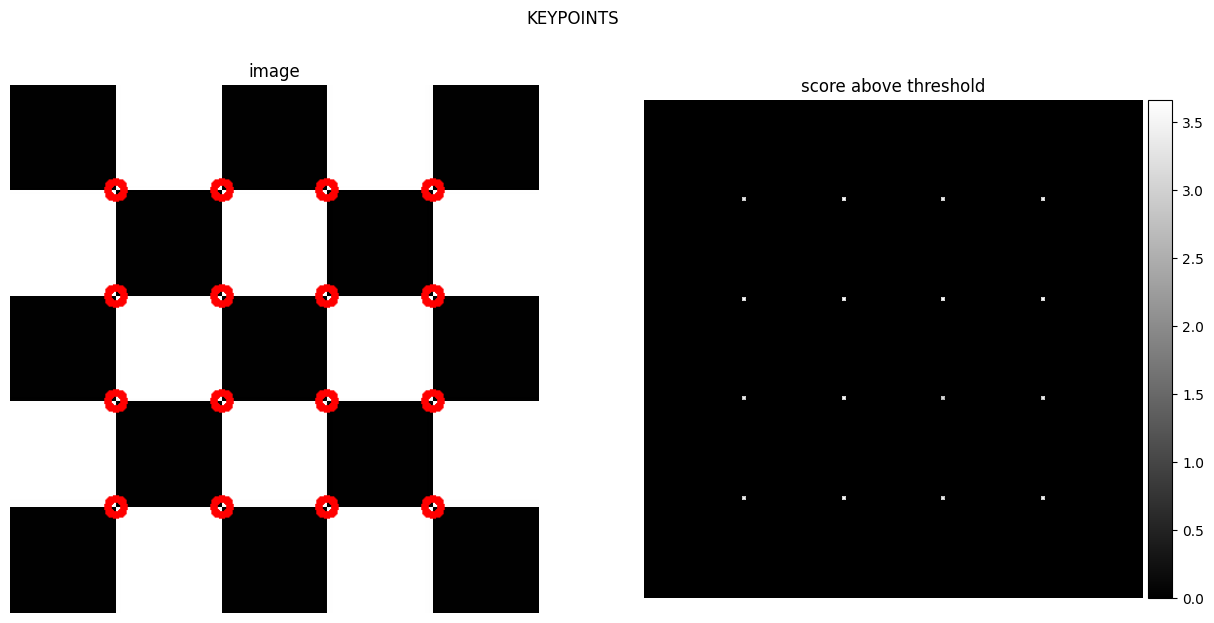

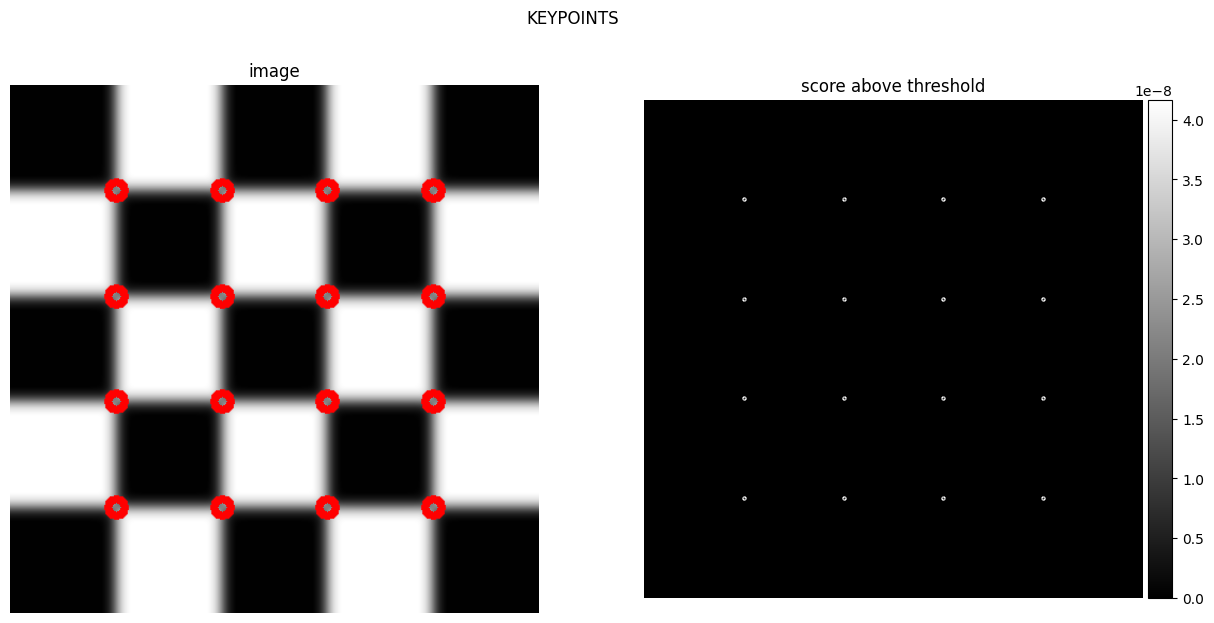

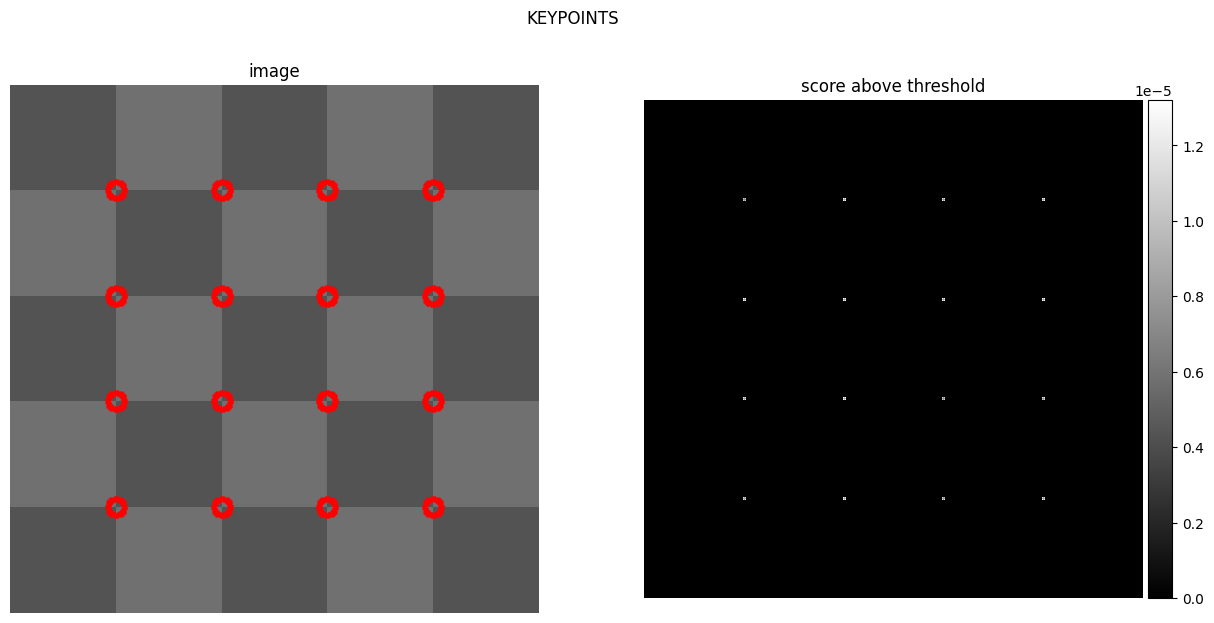

In [ ]:
# detect harris corners and play with the parameters
# TODO: Change these parameters to detect the checkerboard corners
# How do each of the parameters influence the output?
features = HarrisKeypointDetector(grid_img, n=3, w=5, k=0.06, verbose=True)
features = HarrisKeypointDetector(grid_img_blur, n=2, w=3, k=0.04, verbose=True)
features = HarrisKeypointDetector(grid_img_contrast, n=2, w=3, k=0.04, verbose=True)

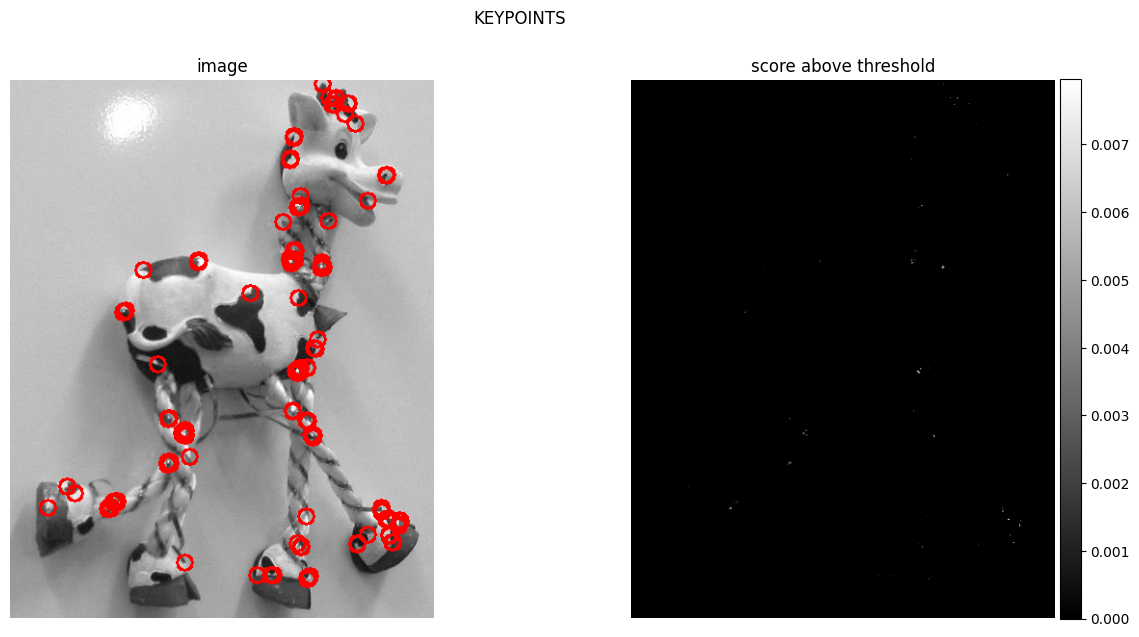

In [ ]:
# real image example
# TODO: Change these parameters to detect the checkerboard corners
# How do each of the parameters influence the output?
features = HarrisKeypointDetector(girf_img_1, n=2, w=3, k=0.04, verbose=True)

############################### FEATURE DESCRIPTION ####################################


In [ ]:
# get simple feature detector with only pixel values around wxw window
def SimpleFeatureDescriptor(grayImage, keypoints, w=5, verbose=False, key_ixs=None):

    # for every keypoint get the pixel values around 5x5 window
    grayImage1 = np.pad(grayImage, [(w,w), (w,w)], mode='constant')
    desc = np.zeros((len(keypoints), w*w), np.float32)

    for i, f in enumerate(keypoints):
        x, y = f.pt
        x, y = np.int32(x), np.int32(y)
        x=x+w
        y=y+w

        each_desc = grayImage1[y - w//2 : y + w//2 + 1,
                               x - w//2 : x + w//2 + 1].reshape([1, w*w])

        desc[i, :] = each_desc

    if verbose:
      assert(len(keypoints) > max(key_ixs))
      fig, ax = plt.subplots(nrows=1, ncols=len(key_ixs), figsize=(15,7))
      for i, ki in enumerate(key_ixs):
        ax[i].imshow(desc[ki, :].reshape((w, w)), cmap='gray')
        ax[i].axis('off')

    return desc

# more robust feature descriptor using ORB
def ORBFeatureDescriptor(grayImage, keypoints):
    orb = cv2.ORB_create() # cv2.SIFT_create()
    kp, des = orb.compute((grayImage * 255).astype(np.uint8), keypoints)
    return des



Keypoint Indices: [19, 97, 51, 26]


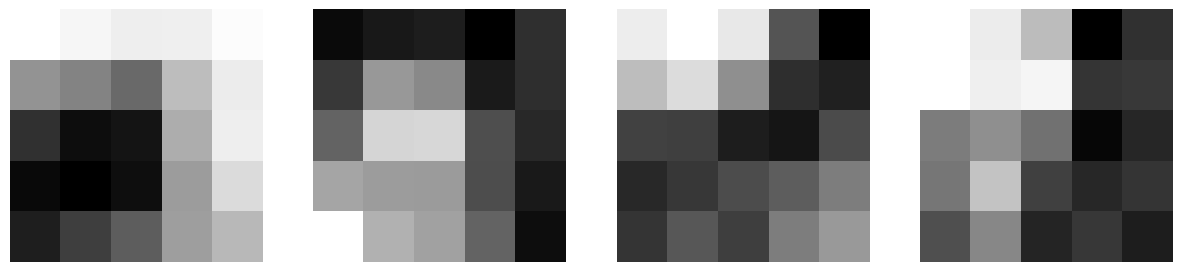

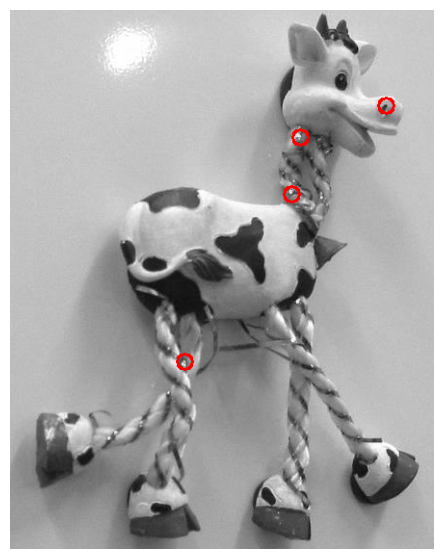

In [ ]:
# extract and display some example features for visualization

ex_kp1 = HarrisKeypointDetector(girf_img_1, n=2, w=3, k=0.04)

ex_w = 5 # window size
key_ixs = [random.randint(0, len(ex_kp1)) for r in range(4)]
print('Keypoint Indices: ' + str(key_ixs))

key_img = drawKeyPts(girf_img_1, [ex_kp1[i] for i in key_ixs])
ex_desc1 = SimpleFeatureDescriptor(girf_img_1, ex_kp1, ex_w, verbose=True, key_ixs=key_ixs)

plt.figure(figsize=(15,7))
plt.imshow(key_img)
plt.axis('off')
plt.show()

############################### FEATURE MATCHING ####################################


In [ ]:
# match the input feature descriptors using a simple brute force search
def feature_matching(desc1, desc2):

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
          good.append(m)

    return good


############################## FEATURE TRACKING ###################################


In [ ]:
# feature tracking pipeline
def feature_tracking(im1, im2, n=2, w=5):

    # detect the features
    kp1 = HarrisKeypointDetector(im1, n=2, w=3, k=0.04)
    kp2 = HarrisKeypointDetector(im2, n=2, w=3, k=0.04)

    # describe features
    desc1 = SimpleFeatureDescriptor(im1, kp1, w)
    desc2 = SimpleFeatureDescriptor(im2, kp2, w)

    # match good features
    good_matches = feature_matching(desc1, desc2)

    # display the matches
    draw_params = dict(matchColor = (255, 0, 0), # draw matches in green
                       singlePointColor = None, # draw only inliers
                       flags = 2)

    match_img = cv2.drawMatches((im1*255).astype(np.uint8), kp1,
                                (im2*255).astype(np.uint8), kp2,
                                good_matches, None, **draw_params)

    fig = plt.figure(figsize=(15,7))
    plt.imshow(match_img)
    plt.axis('off')
    plt.title('MATCHES')
    plt.show()


# Feature tracking example

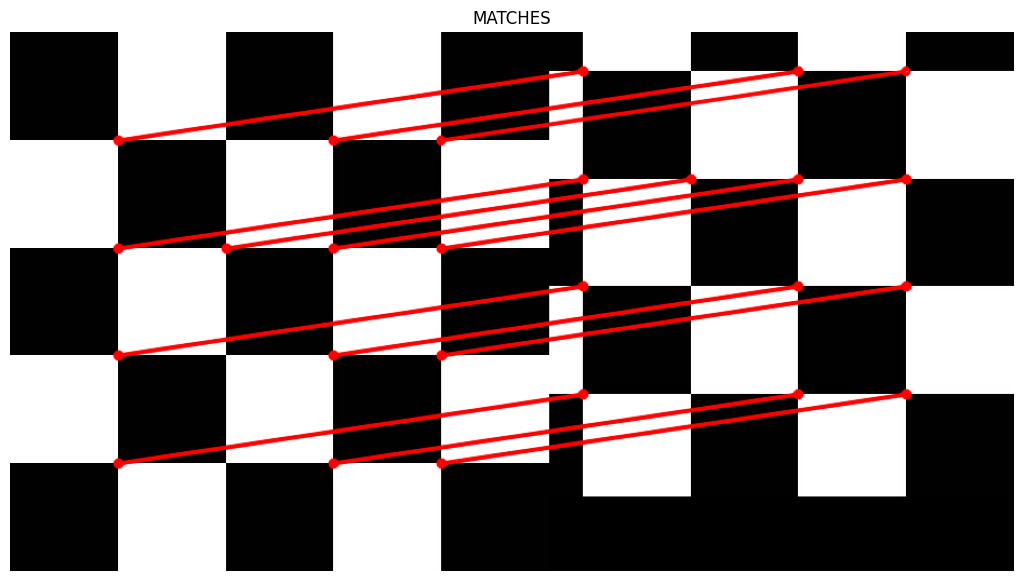

In [ ]:
# TODO: change the parameters to get all correct matches (no crossing lines)
feature_tracking(grid_img, grid_img_translate, w=7)

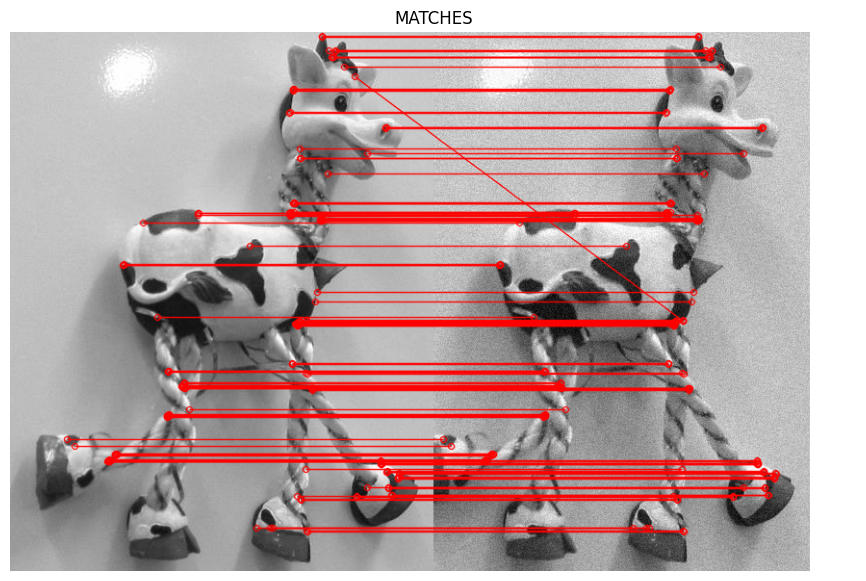

In [ ]:
# TODO: change the parameters to get all correct matches (no crossing lines)
feature_tracking(girf_img_1, girf_img_2, n=9, w=7)

# Failure Case

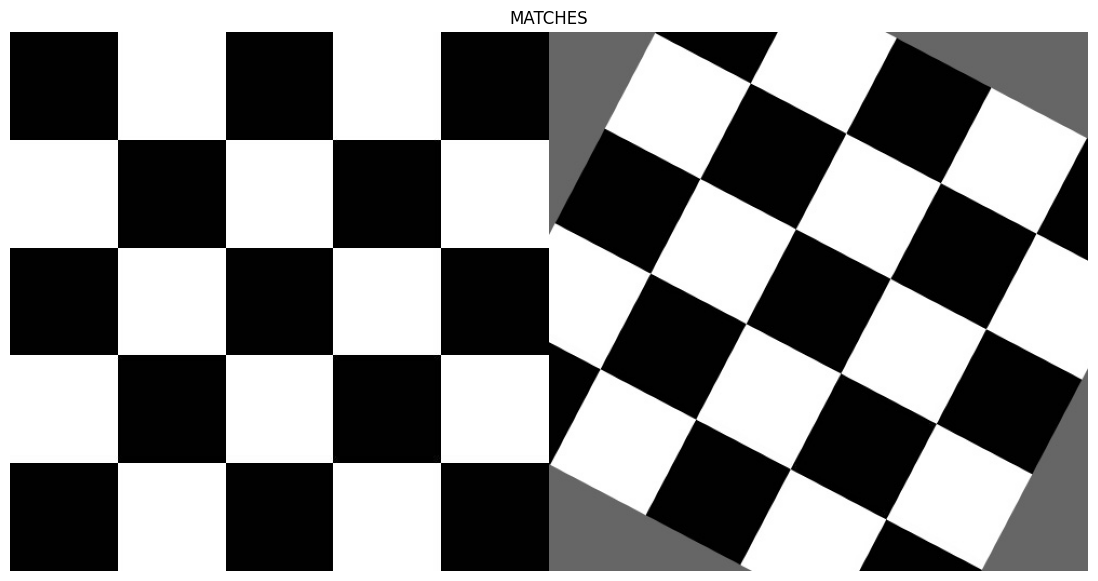

Keypoint Indices: [129, 120, 72, 119]


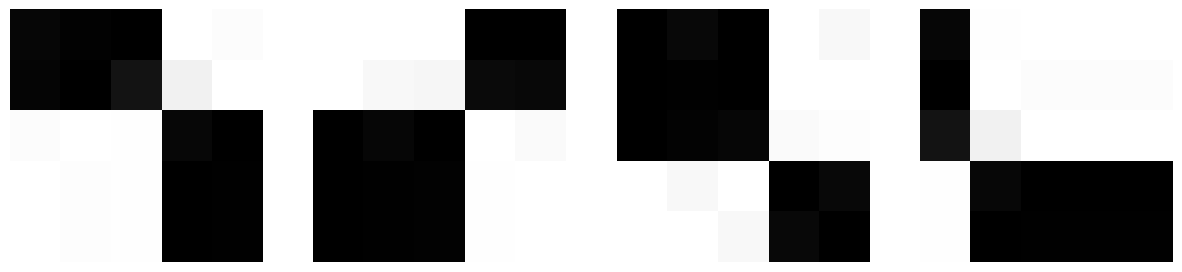

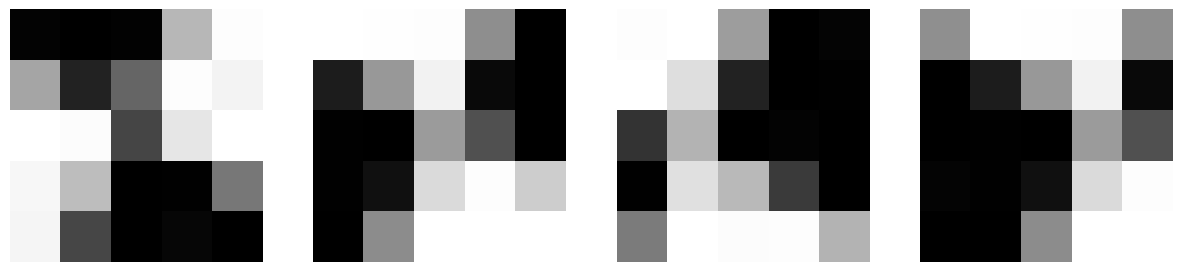

In [ ]:
# TODO: visualize some features from both images
# why is this a failure case for Harris Corner features?
feature_tracking(grid_img, grid_img_rotate, n=2, w=5)

kp_regular = HarrisKeypointDetector(grid_img, n=2, w=3, k=0.04)
kp_rotate = HarrisKeypointDetector(grid_img_rotate, n=2, w=3, k=0.04)

w = 5 # window size
key_ixs = [random.randint(0, len(kp_regular)) for r in range(4)]
print('Keypoint Indices: ' + str(key_ixs))

key_img_regular = drawKeyPts(grid_img, [kp_regular[i] for i in key_ixs])
key_img_rotate = drawKeyPts(grid_img_rotate, [kp_rotate[i] for i in key_ixs])

point_img_regular = SimpleFeatureDescriptor(grid_img, kp_regular, w, verbose=True, key_ixs=key_ixs)
point_img_rotate = SimpleFeatureDescriptor(grid_img_rotate, kp_rotate, w, verbose=True, key_ixs=key_ixs)